In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat


Bad key "text.kerning_factor" on line 4 in
c:\users\maxog\appdata\local\programs\python\python38\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Machine Learning: Programming Exercise 4

## Neural Networks Learning

In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

### 1. Neural Networks

In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.

#### 1.1 Visualizing the data

The code below will load the data and display it on a 2-dimensional plot by calling the function `displayData`. This is the same dataset that you used in the previous exercise. Run the code below to load the training data into the variables `X` and `y`.

In [2]:
def display_data(x, example_width=None):
    if not example_width:
        example_width = int(np.round(np.sqrt(x.shape[1])))

    m, n = x.shape
    example_height = int(n / example_width)

    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    pad = 1

    display_array = -np.ones((pad + display_rows * (example_height + pad), pad + display_cols * (example_width + pad)))

    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex >= m:
                break

            max_val = np.max(np.abs(x[curr_ex, :]))
            display_array[pad + j * (example_height + pad) + np.arange(example_height), pad + i * (
                    example_width + pad) + np.arange(example_width)[:, np.newaxis]] = x[curr_ex, :].reshape(
                (example_height, example_width), order='C') / max_val
            curr_ex += 1

        if curr_ex >= m:
            break

    plt.imshow(display_array, cmap='gray')
    plt.axis('off')
    plt.show()

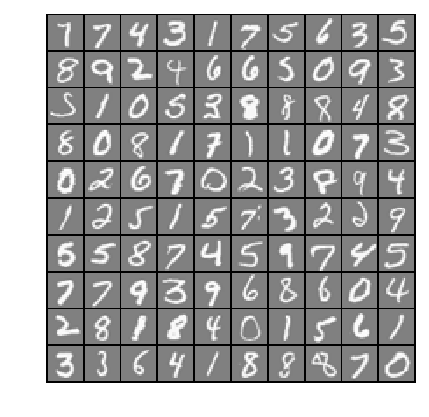

In [3]:
data = loadmat('ex4data1.mat')
X, y = data['X'], data['y'].ravel()
m = X.shape[0]

# Randomly select 100 data points to display
sel = np.random.choice(m, 100, replace=False)
display_data(X[sel, :])

There are 5000 training examples in `ex4data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

$$X = \begin{bmatrix} - (x^{(1)})^T - \\ - (x^{(2)})^T - \\ \vdots \\ - (x^{(m)})^T - \end{bmatrix}$$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. 

#### 1.2 Model representation

Our neural network is shown in the following figure. It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20x20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). 
![image](https://github.com/MaksymAndreiev/ML-Coursera/assets/29687267/a20833a4-98ff-4332-b4dd-df5f51be2b00)
You have been provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained by us. These are stored in `ex4weights.mat` and will be loaded by the code below into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [4]:
# Load the weights into variables Theta1 and Theta2
weights = loadmat('ex4weights.mat')
theta1, theta2 = weights['Theta1'], weights['Theta2']

#### 1.3 Feedforward and cost function

Now you will implement the cost function and gradient for the neural network. First, complete the code in the function `nnCostFunction` to return the cost. Recall that the cost function for the neural network (without regularization) is:

$$J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} \left[ -y_k^{(i)} \log((h_\Theta(x^{(i)}))_k) - (1 - y_k^{(i)}) \log(1 - (h_\Theta(x^{(i)}))_k) \right]$$

where $h_\Theta(x^{(i)})$ is computed as shown in the neural network figure above and K = 10 is the total number of possible labels. Note that $h_\Theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 1, 2, ..., 10, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1, so that

$$y = \begin{bmatrix} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 0 \\ 1 \\ \vdots \\ 0 \end{bmatrix}, \ldots, \begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0. You should implement the feedforward computation that computes $h_\Theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. Your code should also work for a dataset of any size, with any number of labels (you can assume that there are always at least $K \geq 3$ labels).

In [5]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [6]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, input_layer_size + 1))
    theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, hidden_layer_size + 1))

    m = X.shape[0]

    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)

    a1 = np.hstack((np.ones((m, 1)), X))

    z = a1 @ theta1.T
    a2 = sigmoid(z)

    a2 = np.hstack((np.ones((m, 1)), a2))
    z = a2 @ theta2.T
    a3 = sigmoid(z)
    h = a3

    y_new = np.zeros((num_labels, m))  # 10x5000
    y_new[y - 1, np.arange(m)] = 1

    J = (1 / m) * np.sum(-y_new.T * np.log(h) - (1 - y_new.T) * np.log(1 - h))

    t1 = theta1[:, 1:]
    t2 = theta2[:, 1:]

    reg = (lambda_ / (2 * m)) * (np.sum(t1 ** 2) + np.sum(t2 ** 2))
    J = J + reg
    return J

Once you are done, the script will call your `nn_cost_function` using the loaded set of parameters for `theta1` and `theta2`. You should see that the cost is about 0.287629.

In [7]:
input_layer_size = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25  # 25 hidden units
num_labels = 10  # 10 labels, from 1 to 10

# Unroll parameters
nn_params = np.hstack((theta1.ravel(), theta2.ravel())).reshape(-1, 1)

# Weight regularization parameter (we set this to 0 here).
lambda_ = 0

J = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f' % J)

Cost at parameters (loaded from ex4weights): 0.287629


#### 1.4 Regularized cost function

The cost function for neural networks with regularization is given by:

$$J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} \left[ -y_k^{(i)} \log((h_\Theta(x^{(i)}))_k) - (1 - y_k^{(i)}) \log(1 - (h_\Theta(x^{(i)}))_k) \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\Theta_{j,k}^{(2)})^2 \right]$$

You can assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units. While we have explicitly listed the indices above for $\Theta^{(1)}$ and $\Theta^{(2)}$ for clarity, do note that your code should in general work with $\Theta^{(1)}$ and $\Theta^{(2)}$ of any size.
Note that you should not be regularizing the terms that correspond to the bias. For the matrices `Theta1` and `Theta2`, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function $J$ using your existing `nn_cost_function` and then later add the cost for the regularization terms. Once you are done, run the code below to verify that the cost is about 0.383770.

In [8]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1

J = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f' % J)

Cost at parameters (loaded from ex4weights): 0.383770


### 2. Backpropagation

In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. You will need to complete the code in the function `nn_cost_function` so that it returns an appropriate value for `grad`. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(\Theta)$ using an advanced optimizer such as `scipy`'s `optimize.minimize`.
You will first implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. After you have verified that your gradient computation for the unregularized case is correct, you will implement the gradient for the regularized neural network.

#### 2.1 Sigmoid gradient
To help you get started with this part of the exercise, you will first implement the sigmoid gradient function. The gradient for the sigmoid function can be computed as

$$g'(z) = \frac{d}{dz} g(z) = g(z)(1 - g(z))$$

where

$$\text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}}$$

When you are done, try testing a few values by calling `sigmoid_gradient(z)`. For large values (both positive and negative) of `z`, the gradient should be close to 0. When $z = 0$, the gradient should be exactly 0.25. Your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid gradient function on every element.

In [9]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [10]:
# Call your sigmoid gradient function
sigmoid_gradient(0)

0.25

#### 2.2 Random initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.
Your job is to complete the function `rand_initialize_weights` to initialize the weights for $\Theta$. 

In [11]:
def rand_initialize_weights(l_in, l_out):
    # Randomly initialize the weights to small values
    epsilon_init = 0.12
    w = np.random.rand(l_out, l_in + 1) * 2 * epsilon_init - epsilon_init
    return w

When you are done, run the code below to call `rand_initialize_weights` and initialize the neural network parameters.

In [12]:
initial_theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size)
initial_theta2 = rand_initialize_weights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.hstack((initial_theta1.ravel(), initial_theta2.ravel())).reshape(-1, 1)

*One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$, where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{(l)}$.

#### 2.3 Backpropagation

Now, you will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a "forward pass" to compute all the activations throughout the network, including the output value of the hypothesis $h_\Theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an "error term" $\delta_j^{(l)}$ that measures how much that node was "responsible" for any errors in our output.
For an output node, we can directly measure the difference between the network's activation and the true target value, and use that to define $\delta_j^{(3)}$ (where layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l + 1)$.
![image](https://github.com/MaksymAndreiev/ML-Coursera/assets/29687267/892fe23a-8e74-4f89-96a2-ff662418def9)
In detail, here is the backpropagation algorithm (also depicted in the figure above). You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop for $t = 1:m$ and place steps 1-4 below inside the for-loop, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example $(x^{(t)}, y^{(t)})$. Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network cost function.

1. Set the input layer's values $(a^{(1)})$ to the $t^{th}$ training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a +1 term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. In `numpy`, if a 1 is a column matrix, adding one corresponds to `a_1 = np.concatenate([np.ones((1, 1)), a_1], axis=0)`.
2. For each output unit $k$ in layer 3 (the output layer), set $\delta_k^{(3)} = (a_k^{(3)} - y_k)$ where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).
3. For the hidden layer $l = 2$, set $$\delta^{(2)} = (\Theta^{(2)})^T \delta^{(3)} .* g'(z^{(2)})$$
4. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$. In `numpy`, removing $\delta_0^{(2)}$ corresponds to `delta_2 = delta_2[1:]`.
5. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$: $\frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$

In [13]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, input_layer_size + 1))
    theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, hidden_layer_size + 1))

    m = X.shape[0]

    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)

    a1 = np.hstack((np.ones((m, 1)), X))
    print(a1.shape)

    z = a1 @ theta1.T
    a2 = sigmoid(z)

    a2 = np.hstack((np.ones((m, 1)), a2))
    z = a2 @ theta2.T
    a3 = sigmoid(z)
    h = a3

    y_new = np.zeros((num_labels, m))  # 10x5000
    y_new[y - 1, np.arange(m)] = 1

    J = (1 / m) * np.sum(-y_new.T * np.log(h) - (1 - y_new.T) * np.log(1 - h))

    t1 = theta1[:, 1:]
    t2 = theta2[:, 1:]

    reg = (lambda_ / (2 * m)) * (np.sum(t1 ** 2) + np.sum(t2 ** 2))
    J = J + reg

    X = np.hstack((np.ones((m, 1)), X))
    for t in range(m):
        a1 = X[t, :].T.reshape(-1, 1)
        
        z2 = theta1 @ a1
        a2 = sigmoid(z2)

        a2 = np.vstack((np.ones(1), a2))
        z3 = theta2 @ a2
        a3 = sigmoid(z3)

        delta3 = a3 - y_new[:, t].reshape(-1, 1)

        z2 = np.vstack((np.ones(1), z2))
        delta2 = (theta2.T @ delta3) * sigmoid(z2)

        delta2 = delta2[1:]
        theta1_grad = theta1_grad + delta2 @ a1.T
        theta2_grad = theta2_grad + delta3 @ a2.T

    theta1_grad = theta1_grad / m
    theta2_grad = theta2_grad / m

    theta1_grad[:, 1:] = theta1_grad[:, 1:] + (lambda_ / m) * theta1[:, 1:]
    theta2_grad[:, 1:] = theta2_grad[:, 1:] + (lambda_ / m) * theta2[:, 1:]

    # Unroll gradients
    grad = np.hstack((theta1_grad.ravel(order='F'), theta2_grad.ravel(order='F'))).reshape(-1, 1)

    return J, grad

After you have implemented the backpropagation algorithm, the code in the next section will run gradient checking on your implementation. The gradient check will allow you to increase your confidence that your code is computing the gradients correctly.

#### 2.4 Gradient checking

In your neural network, you are minimizing the cost function $J(\Theta)$. To perform gradient checking on your parameters, you can imagine "unrolling" the parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\theta$. By doing so, you can think of the cost function being $J(\Theta)$ instead and use the following gradient checking procedure.
Suppose you have a function $J(\Theta)$ that purportedly computes $\frac{\partial}{\partial \Theta_{i}} J(\Theta)$, you'd like to check if $f_i$ is outputting correct derivative values.
$$\text{Let } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix} \text{ and } \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}$$
So, $\theta^{(i+)}$ is the same as $\theta$, except its $i^{th}$ element has been incremented by $\epsilon$. Similarly, $\theta^{(i-)}$ is the corresponding vector with the $i^{th}$ element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$'s correctness by checking, for each $i$, that:
$$f_i(\theta) \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2\epsilon}$$
The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon = 10^{-4}$, you'll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more). We have implemented the function to compute the numerical gradient for you in `compute_numerical_gradient`. While you are not required to modify the file, we highly encourage you to take a look at the code to understand how it works.

In [14]:
def compute_numerical_gradient(J, theta):
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4
    for p in range(theta.size):
        perturb[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)
        numgrad[p] = (loss2 - loss1) / (2 * e)
        perturb[p] = 0
    return numgrad

The code below will run the provided function `check_nn_gradients` which will create a small neural network and dataset that will be used for checking your gradients. If your backpropagation implementation is correct, you should see a relative difference that is less than 1e-9.

In [15]:
def check_nn_gradients():
    """
    Creates a small neural network to check the backpropagation gradients. It will output the analytical gradients produced by your backprop code and the numerical gradients (computed using compute_numerical_gradient). These two gradient computations should result in very similar values.
    """
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    theta1 = rand_initialize_weights(hidden_layer_size, input_layer_size)
    theta2 = rand_initialize_weights(num_labels, hidden_layer_size)
    # Reusing debugInitializeWeights to generate X
    X = rand_initialize_weights(input_layer_size - 1, m)
    print(X.shape)
    y = 1 + np.mod(np.arange(1, m + 1), num_labels)

    # Unroll parameters
    nn_params = np.hstack((theta1.ravel(), theta2.ravel())).reshape(-1, 1)

    # Short hand for cost function
    cost_func = lambda p: nn_cost_function(p, input_layer_size, hidden_layer_size, num_labels, X, y, 0)
    cost, grad = cost_func(nn_params)
    numgrad = compute_numerical_gradient(cost_func, nn_params)

    # Visually examine the two gradient computations.  The two columns you get should be very similar.
    print(numgrad.shape)
    print(grad.shape)
    print(np.stack((numgrad, grad), axis=1))
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n')

    # Evaluate the norm of the difference between two solutions. If you have a correct implementation, and assuming you used e = 0.0001 in computeNumericalGradient, then diff below should be less than 1e-9
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    print(
        'If your backpropagation implementation is correct, then the relative difference will be small (less than 1e-9).')
    print('Relative Difference: %g' % diff)

In [16]:
check_nn_gradients()

(5, 3)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(5, 4)
(38, 1)
(38, 1)
[[[ 9.82795227e-03]
  [ 2.06925287e-02]]

 [[ 3.88737027e-04]
  [ 1.10178283e-03]]

 [[-1.46571244e-04]
  [ 1.47134044e-02]]

 [[ 7.31975285e-04]
  [-1.98450186e-02]]

 [[ 4.99724992e-04]
  [-4.37423126e-03]]

 [[-6.73195726e-04]
  [ 8.21766467e-04]]

 [[-3.16352367e-04]
  [-1.41482981e-03]]

 [[-4.74786410e-05]
  [-4.21331911e-04]]

 [[ 7.04450902e-03]
  [-1.86791540e-03]]

 [[-2.02317665e-04]
  [-8.28595994e-04]]

 [[-3.59944796e-04